In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.applications import vgg16 as _vgg16
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import tf_explain
import skimage.io

from tf_explain.core import GradCAM
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, DeepFool

import shap
import tensorflow.compat.v1.keras.backend as K

In [2]:
#Load pretrained model 

# from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
# model = tf.keras.models.load_model('..\\data\\model')

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions 
model=VGG16()

# from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
# model=VGG19()

# from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions
# model=MobileNet()

# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
# model=InceptionV3()

In [3]:
def tab(img):
    #making prediction
    preds = np.round(model.predict(preprocess_input(np.expand_dims(img.copy(), axis=0))),5)
    predict=[]

    if (model.name=='AkinolaVGG16'):
        class_names={'0':'chimpanzee', '1':'gorilla','2':'white_tiger'}
        preds_data = dict(zip(class_names.values(), preds[0]))
    else:
        decoded_preds=decode_predictions(preds,top=10)
        class_names={}
        ind =(-preds[0]).argsort()[:10]
        for i in range (10):
            class_names[str(ind[i])]=decoded_preds[0][i][1]
            predict.append(decoded_preds[0][i][2])
        preds_data = dict(zip(class_names.values(), predict))

    #plot results
    plt.bar(range(len(preds_data)), list(preds_data.values()), align='center')
    plt.xticks(range(len(preds_data)), list(preds_data.keys()),rotation=45,va='center_baseline',horizontalalignment='right')
    plt.show

In [4]:
img = tf.keras.preprocessing.image.load_img("..\\XAI_libraries\\image5.jpg", target_size=(224, 224))
# img = tf.keras.preprocessing.image.load_img("image4.jpg", target_size=(299, 299)) # inceptionv3
# img = np.array(img)

img = tf.keras.preprocessing.image.img_to_array(img)
img = np.reshape(img,[-1,224,224,3])

In [5]:
X,y = shap.datasets.imagenet50()

In [6]:
# defining shap vals layer method

def shap_vals_layer(n):
  # explain how the input to the "n" layer of the model explains the top two classes
  def map2layer(x, layer):
      feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
      return K.get_session().run(model.layers[layer].input, feed_dict)
  e = shap.GradientExplainer(
      (model.layers[n].input, model.layers[-1].output),
      map2layer(X, n),
      local_smoothing=1 # std dev of smoothing noise
  )

  shap_values,indexes = e.shap_values(map2layer(to_explain, n),ranked_outputs=3)
  return (shap_values,indexes)

In [7]:
classifier = KerasClassifier( model=model, clip_values=(0, 255))

In [8]:
# attack = FastGradientMethod(classifier,eps=5,targeted=True)
attack = DeepFool(classifier,epsilon=20)

In [9]:
img_adv = attack.generate(img,y=[289])

DeepFool: 100%|██████████| 1/1 [00:05<00:00,  5.37s/it]


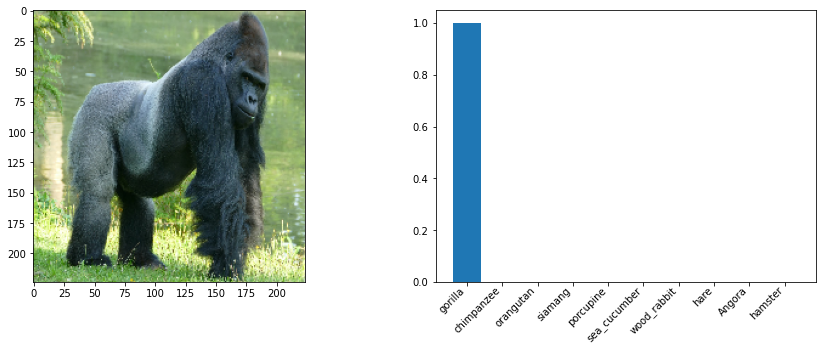

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].imshow(img[0]/255)
axes[1]=tab(img[0])

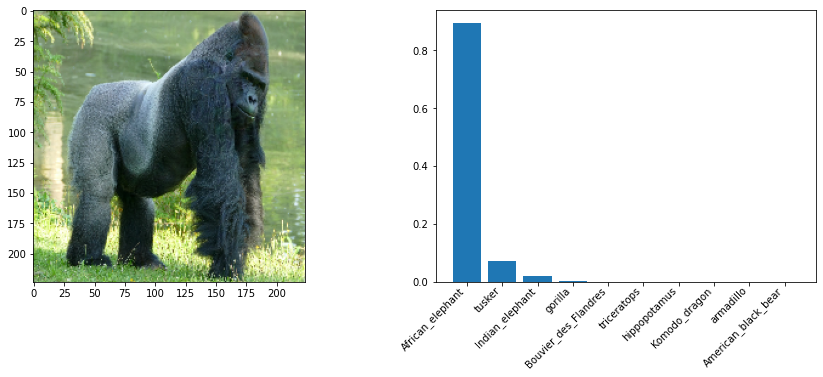

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
axes[0].imshow(img_adv[0]/255)
axes[1]=tab(img_adv[0])

In [12]:
value,index=shap_vals_layer(15)
shap.image_plot(value,img,np.vectorize(lambda x: class_names[str(x)])(index))

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[50,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block1_conv1/Relu (defined at <ipython-input-2-f49ddcce1d6a>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[block4_pool/MaxPool/_239]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[50,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node block1_conv1/Relu (defined at <ipython-input-2-f49ddcce1d6a>:7) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

Original stack trace for 'block1_conv1/Relu':
  File "C:\Users\samsn\anaconda3\envs\tfv1\lib\runpy.py", line 192, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\samsn\anaconda3\envs\tfv1\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\traitlets\config\application.py", line 845, in launch_instance
    app.start()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelapp.py", line 612, in start
    self.io_loop.start()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\platform\asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\samsn\anaconda3\envs\tfv1\lib\asyncio\base_events.py", line 563, in run_forever
    self._run_once()
  File "C:\Users\samsn\anaconda3\envs\tfv1\lib\asyncio\base_events.py", line 1844, in _run_once
    handle._run()
  File "C:\Users\samsn\anaconda3\envs\tfv1\lib\asyncio\events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\ioloop.py", line 741, in _run_callback
    ret = callback()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 374, in dispatch_queue
    yield self.process_one()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 358, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 261, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\kernelbase.py", line 536, in execute_request
    self.do_execute(
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tornado\gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\ipkernel.py", line 302, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\ipykernel\zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2894, in run_cell
    result = self._run_cell(
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
    return runner(coro)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3165, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3357, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-f49ddcce1d6a>", line 7, in <module>
    model=VGG16()
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\applications\vgg16.py", line 143, in VGG16
    x = layers.Conv2D(
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\base_layer_v1.py", line 786, in __call__
    outputs = call_fn(cast_inputs, *args, **kwargs)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\layers\convolutional.py", line 270, in call
    return self.activation(outputs)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\activations.py", line 306, in relu
    return K.relu(x, alpha=alpha, max_value=max_value, threshold=threshold)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\backend.py", line 4706, in relu
    x = nn.relu(x)
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 10483, in relu
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\op_def_library.py", line 748, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py", line 3528, in _create_op_internal
    ret = Operation(
  File "C:\Users\samsn\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\framework\ops.py", line 1990, in __init__
    self._traceback = tf_stack.extract_stack()
